In [8]:
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

C:\Users\USER\AppData\Local\Temp\ipykernel_33220\433361478.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stockData = yf.download(ticker, period='2y')
[*********************100%***********************]  4 of 4 completed


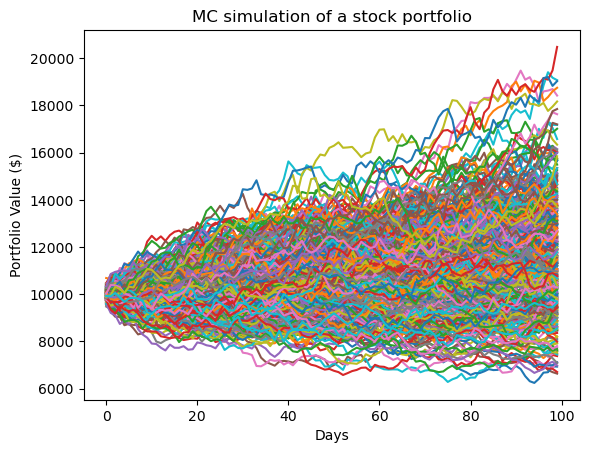

VaR_5 $1932.86
CVaR_5 $2585.81


In [ ]:
def get_data(ticker):
    stockData = yf.download(ticker, period='2y')
    stockData = stockData["Close"]
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covReturns = returns.cov()
    return meanReturns, covReturns

tickers = ['MSFT', 'AAPL', 'GOOG', 'TSLA']

meanReturns, covMatrix = get_data(tickers)

weights = np.random.random(len(meanReturns))# randomize weights
weights /= np.sum(weights)

# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days

meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)

initialPortfolio = 10000

for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio

plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")


portResults = pd.Series(portfolio_sims[-1,:])

VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)

print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))